In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

2024-05-16 19:06:38.651143: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-16 19:06:40.603499: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 19:06:40.604691: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-16 19:06:41.287539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-16 19:06:41.291334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key_fulldata(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(10198, 512, 512, 1) (10198, 512, 512, 1) (6568, 512, 512, 1) (6568, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(10198, 512, 512, 1) (6568, 512, 512, 1)


In [12]:
train_images_array, test_images_array = C.Helper.masked_image(X_train, m_train, X_test, m_test)

(10198, 512, 512, 1) (6568, 512, 512, 1)


In [13]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [14]:
X_train_set.shape, y_train_set.shape, X_val.shape, y_val.shape

((8136, 512, 512, 1),
 (8136, 512, 512, 1),
 (2062, 512, 512, 1),
 (2062, 512, 512, 1))

In [15]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-16 19:10:00.271809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-16 19:10:00.275528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-16 19:10:00.291306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-16 19:10:00.295656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-16 19:10:00.299537: I tensorflow/core

In [16]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-16 19:10:02.735368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-16 19:10:02.754770: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-16 19:10:04.362587: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-16 19:10:04.967987: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-16 19:10:05.619769: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-16 19:10:05.619793: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-16 19:10:05.619850: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-16 19:10:05.689829: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-16 19:10:06.384655: I tensorflow/stream_exec

508/508 [==============================] - 242s 453ms/step - loss: 0.1128 - iou: 2.1306e-05 - iou_thresholded: 0.3491 - val_loss: 0.0053 - val_iou: 5.2402e-05 - val_iou_thresholded: 0.9186
Epoch 2/200
508/508 [==============================] - 233s 448ms/step - loss: 0.0026 - iou: 1.2999e-04 - iou_thresholded: 0.5408 - val_loss: 0.0013 - val_iou: 2.3219e-04 - val_iou_thresholded: 0.8999
Epoch 3/200
508/508 [==============================] - 227s 448ms/step - loss: 8.7818e-04 - iou: 3.7697e-04 - iou_thresholded: 0.5028 - val_loss: 5.8695e-04 - val_iou: 4.3377e-04 - val_iou_thresholded: 0.9186
Epoch 4/200
508/508 [==============================] - 227s 448ms/step - loss: 4.4362e-04 - iou: 8.0252e-04 - iou_thresholded: 0.4945 - val_loss: 3.1338e-04 - val_iou: 0.0012 - val_iou_thresholded: 0.8498
Epoch 5/200
508/508 [==============================] - 227s 448ms/step - loss: 3.2156e-04 - iou: 0.0015 - iou_thresholded: 0.4905 - val_loss: 3.1151e-04 - val_iou: 9.9838e-04 - val_iou_thresholded

508/508 [==============================] - 228s 448ms/step - loss: 1.6271e-05 - iou: 0.2417 - iou_thresholded: 0.6418 - val_loss: 2.1276e-05 - val_iou: 0.4757 - val_iou_thresholded: 0.9079
Epoch 42/200
508/508 [==============================] - 228s 448ms/step - loss: 1.5068e-05 - iou: 0.2440 - iou_thresholded: 0.6681 - val_loss: 2.0128e-05 - val_iou: 0.5280 - val_iou_thresholded: 0.9130
Epoch 43/200
508/508 [==============================] - 227s 448ms/step - loss: 1.3372e-05 - iou: 0.2827 - iou_thresholded: 0.6880 - val_loss: 2.8975e-05 - val_iou: 0.4385 - val_iou_thresholded: 0.8651
Epoch 44/200
508/508 [==============================] - 228s 448ms/step - loss: 1.2719e-05 - iou: 0.2841 - iou_thresholded: 0.6823 - val_loss: 2.2346e-05 - val_iou: 0.5541 - val_iou_thresholded: 0.9067
Epoch 45/200
508/508 [==============================] - 227s 448ms/step - loss: 1.3319e-05 - iou: 0.2781 - iou_thresholded: 0.6889 - val_loss: 2.0755e-05 - val_iou: 0.5026 - val_iou_thresholded: 0.8766
Epo

Epoch 82/200
508/508 [==============================] - 228s 448ms/step - loss: 7.1933e-06 - iou: 0.4914 - iou_thresholded: 0.8154 - val_loss: 5.9187e-05 - val_iou: 0.5687 - val_iou_thresholded: 0.9109
Epoch 83/200
508/508 [==============================] - 228s 448ms/step - loss: 8.4734e-06 - iou: 0.4435 - iou_thresholded: 0.7747 - val_loss: 4.0365e-05 - val_iou: 0.4950 - val_iou_thresholded: 0.9143
Epoch 84/200
508/508 [==============================] - 228s 448ms/step - loss: 8.1390e-06 - iou: 0.4561 - iou_thresholded: 0.7991 - val_loss: 3.5560e-05 - val_iou: 0.6030 - val_iou_thresholded: 0.9372
Epoch 85/200
508/508 [==============================] - 228s 448ms/step - loss: 6.8965e-06 - iou: 0.5162 - iou_thresholded: 0.8202 - val_loss: 3.8632e-05 - val_iou: 0.5714 - val_iou_thresholded: 0.9251
Epoch 86/200
508/508 [==============================] - 228s 448ms/step - loss: 7.3083e-06 - iou: 0.4880 - iou_thresholded: 0.7994 - val_loss: 4.0911e-05 - val_iou: 0.6158 - val_iou_thresholde

508/508 [==============================] - 228s 448ms/step - loss: 5.9228e-06 - iou: 0.5355 - iou_thresholded: 0.8368 - val_loss: 4.2112e-05 - val_iou: 0.6328 - val_iou_thresholded: 0.9113
Epoch 123/200
508/508 [==============================] - 228s 448ms/step - loss: 6.1265e-06 - iou: 0.5984 - iou_thresholded: 0.8485 - val_loss: 4.3191e-05 - val_iou: 0.5613 - val_iou_thresholded: 0.9098
Epoch 124/200
508/508 [==============================] - 227s 448ms/step - loss: 5.6405e-06 - iou: 0.5710 - iou_thresholded: 0.8486 - val_loss: 4.3294e-05 - val_iou: 0.6096 - val_iou_thresholded: 0.9336
Epoch 125/200
508/508 [==============================] - 227s 448ms/step - loss: 6.0439e-06 - iou: 0.5858 - iou_thresholded: 0.8449 - val_loss: 5.2204e-05 - val_iou: 0.5659 - val_iou_thresholded: 0.9021
Epoch 126/200
508/508 [==============================] - 227s 448ms/step - loss: 5.1559e-06 - iou: 0.6026 - iou_thresholded: 0.8666 - val_loss: 4.9127e-05 - val_iou: 0.6689 - val_iou_thresholded: 0.9081

508/508 [==============================] - 228s 448ms/step - loss: 3.7534e-06 - iou: 0.6979 - iou_thresholded: 0.8931 - val_loss: 5.0599e-05 - val_iou: 0.6362 - val_iou_thresholded: 0.9366
Epoch 163/200
508/508 [==============================] - 228s 448ms/step - loss: 4.1150e-06 - iou: 0.6834 - iou_thresholded: 0.8966 - val_loss: 4.3882e-05 - val_iou: 0.7240 - val_iou_thresholded: 0.9287
Epoch 164/200
508/508 [==============================] - 228s 448ms/step - loss: 5.8143e-06 - iou: 0.6333 - iou_thresholded: 0.8877 - val_loss: 6.2249e-05 - val_iou: 0.5806 - val_iou_thresholded: 0.9302
Epoch 165/200
508/508 [==============================] - 227s 448ms/step - loss: 4.4389e-06 - iou: 0.6788 - iou_thresholded: 0.8952 - val_loss: 5.4414e-05 - val_iou: 0.5823 - val_iou_thresholded: 0.9294
Epoch 166/200
508/508 [==============================] - 227s 448ms/step - loss: 4.2949e-06 - iou: 0.6755 - iou_thresholded: 0.8959 - val_loss: 5.4141e-05 - val_iou: 0.6591 - val_iou_thresholded: 0.9255

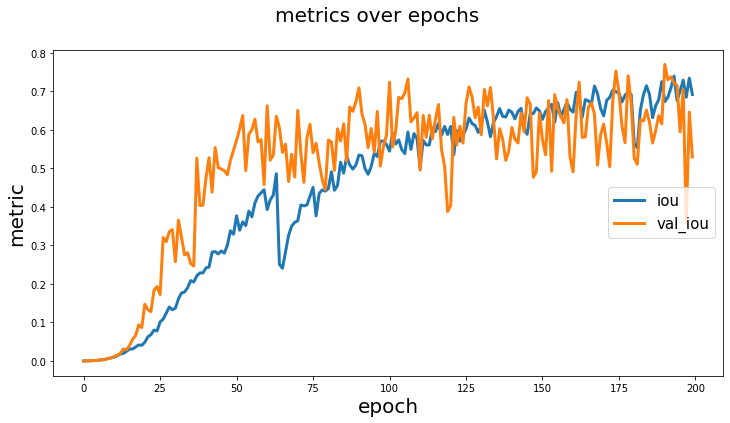

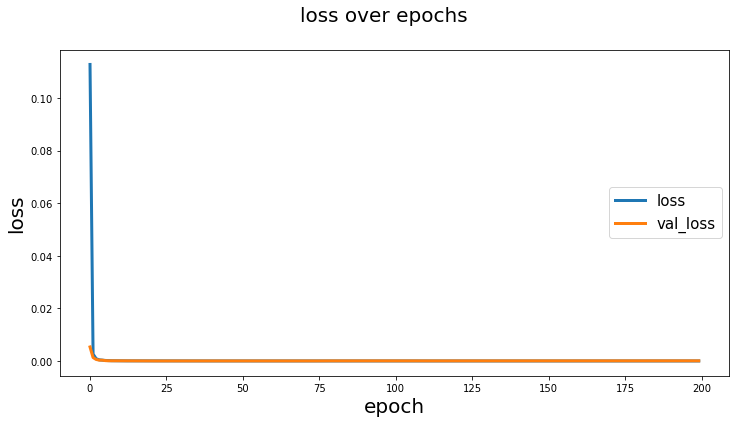

In [17]:
C.Helper.visualize_graph(history)

In [18]:
y_pred = C.Helper.prediction(test_images_array, model)

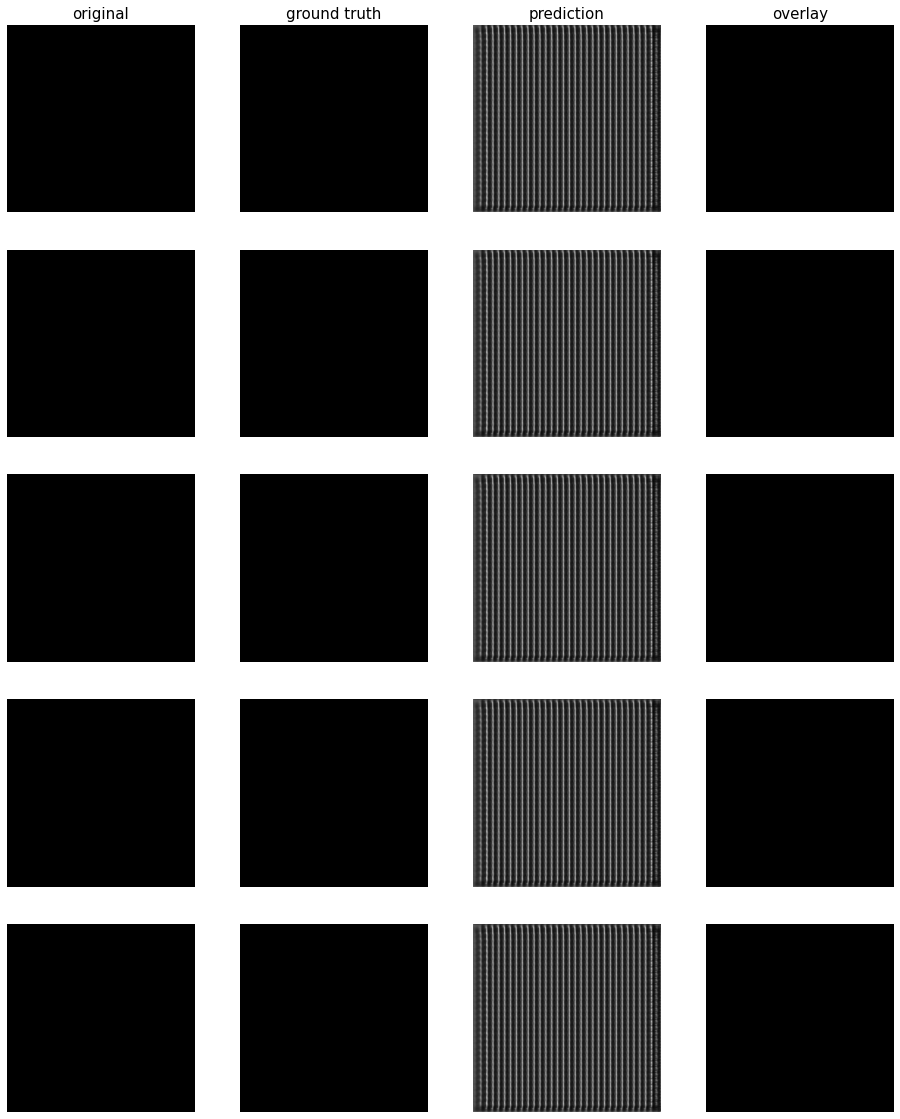

In [19]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [20]:
C.Helper.evaluate(test_images_array, y_test, model)

206/206 [==============================] - 54s 260ms/step - loss: 8.0273e-05 - iou: 0.3670 - iou_thresholded: 0.8118
